<a href="https://colab.research.google.com/github/hiydavid/nike-air-classifier/blob/main/nike_air_classifier_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nike Air Classifier (Training)
#### Training a model to classify betwen Nike Air Jordan 1, Air Max 1, and Air Force 1 sneakers

In [1]:
# load libraries
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 727kB 18.9MB/s 
     |████████████████████████████████| 194kB 27.2MB/s 
     |████████████████████████████████| 1.2MB 37.0MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
Mounted at /content/gdrive


In [2]:
# function to get image from DDG
def search_images_ddg_corrected(term, max_images = 200):
    assert max_images < 1000
    url = 'https://duckduckgo.com/'
    res = urlread(url, data = {'q' : term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(
        l = 'us-en', o = 'json', q = term, 
        vqd = searchObj.group(1), f = ',,,', 
        p = '1', v7exp = 'a')
    urls, data = set(), {'next' : 1}
    while len(urls)<max_images and 'next' in data:
        try:
            data = urljson(requestUrl, data = params)
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError, HTTPError): 
            pass
        time.sleep(0.2)
    return L(urls)

In [3]:
# setup path for API to download images
bear_types = 'airjordan1', 'airmax1', 'airforce1'
image_path = Path(r'gdrive/MyDrive/Colab/projects/nike_air_classifier/images')

In [4]:
# # remove existing path
# !rm -rf gdrive/MyDrive/Colab/projects/nike_air_classifier/images

In [5]:
# # get images for each bear types based on URLs
# from tqdm import tqdm # see download progress

# if not image_path.exists():
#     image_path.mkdir()
#     for o in tqdm(bear_types):
#         dest = (image_path/o)
#         dest.mkdir(exist_ok = True)
#         results = search_images_ddg_corrected(f'nike {o}', max_images = 200)
#         download_images(dest, urls = results)

In [6]:
# get file names of the images we just downloaded
fns = get_image_files(image_path)
fns

(#652) [Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000004.jpg'),Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000000.jpg'),Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000002.jpeg'),Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000010.jpg'),Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000013.jpg'),Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000012.jpg'),Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000017.jpg'),Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000001.jpg'),Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000016.jpg'),Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airjordan1/00000015.jpg')...]

In [7]:
# check for images that cannot be opened
failed = verify_images(fns)
failed

(#1) [Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/images/airforce1/00000149.jpg')]

In [8]:
# remove failed images
failed.map(Path.unlink)

(#1) [None]

In [9]:
# first create datablock for dataloader
nikeair = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128)
    )

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


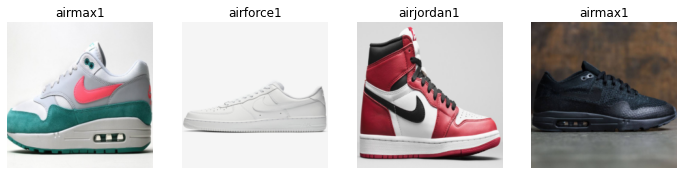

In [10]:
# resize to 224x224 and create dataloader object
nikeair = nikeair.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms())
dls = nikeair.dataloaders(image_path)
dls.valid.show_batch(max_n = 4, nrows = 1)

In [11]:
# use pre-trained model with restnet with 18 layers 
learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.614784,1.078492,0.338462,00:21


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.763108,0.705021,0.230769,00:21
1,0.636437,0.599725,0.153846,00:21
2,0.507047,0.488368,0.138462,00:21
3,0.408133,0.466301,0.130769,00:21


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

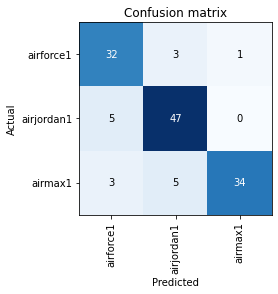

In [12]:
# interpret results via confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

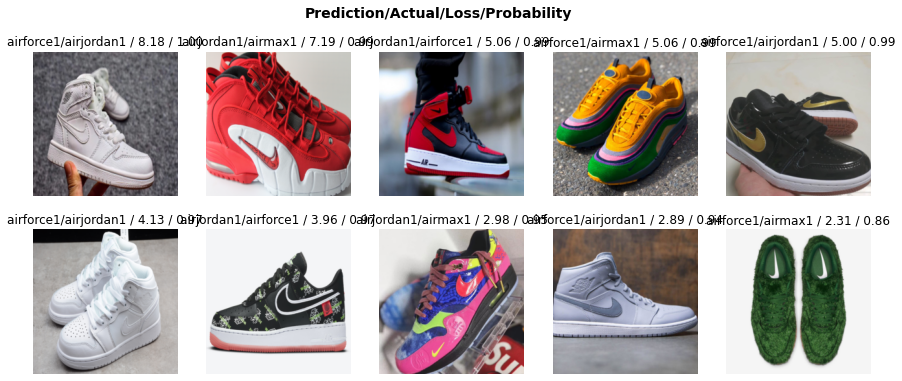

In [13]:
# check top 5 images with highest prediction loss
interp.plot_top_losses(10, nrows = 2)

In [14]:
# exports model into a pickle (.pkl) file
learn.export()

In [16]:
# check to see if .pkl exists
model_path = Path(r'gdrive/MyDrive/Colab/projects/nike_air_classifier')
model_path.ls(file_exts = '.pkl')

(#1) [Path('gdrive/MyDrive/Colab/projects/nike_air_classifier/export.pkl')]